# Probabilistic Methods of Anomaly Detection (Discrete)

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

## Acquire Data

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.tail()

,ip,timestamp,request_method,status,size,destination,request_agent
13973,97.105.19.58,[17/Apr/2019:12:55:14 +0000],"""GET /api/v1/sales?page=71 HTTP/1.1""",200,510166,NaN,"""python-requests/2.21.0"""
0,95.31.18.119,[21/Apr/2019:10:02:41+0000],GET /api/v1/items/HTTP/1.1,200,1153005,NaN,python-requests/2.21.0
1,95.31.16.121,[17/Apr/2019:19:36:41+0000],GET /api/v1/sales?page=79/HTTP/1.1,301,1005,NaN,python-requests/2.21.0
2,97.105.15.120,[18/Apr/2019:19:42:41+0000],GET /api/v1/sales?page=79/HTTP/1.1,301,2560,NaN,python-requests/2.21.0
3,97.105.19.58,[19/Apr/2019:19:42:41+0000],GET /api/v1/sales?page=79/HTTP/1.1,200,2056327,NaN,python-requests/2.21.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [13]:
df.loc[df['destination'].notnull()]

,ip,timestamp,request_method,status,size,destination,request_agent
174,97.105.19.58,[16/Apr/2019:19:38:16 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/V1/HiZach!""","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
566,97.105.19.58,[16/Apr/2019:19:44:04 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/v1/stores?page=0""","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
583,97.105.19.58,[16/Apr/2019:19:44:16 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/v1/stores?page=1""","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
596,97.105.19.58,[16/Apr/2019:19:44:24 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/v1/stores?page=1""","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
602,97.105.19.58,[16/Apr/2019:19:44:28 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/v1/stores?page=2""","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
618,97.105.19.58,[16/Apr/2019:19:44:38 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/v1/stores?page=999""","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
676,97.105.19.58,[16/Apr/2019:19:45:20 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/v1/items?page=0""","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
1117,97.105.19.58,[16/Apr/2019:19:49:41 +0000],"""GET /api/v1//api/v1/items?page=2 HTTP/1.1""",200,162,"""http://localhost:8889/notebooks/timeseries_ac...","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
1123,97.105.19.58,[16/Apr/2019:19:49:43 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/v1//api/v1/items?...","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."
1146,97.105.19.58,[16/Apr/2019:19:49:53 +0000],"""GET /favicon.ico HTTP/1.1""",200,162,"""https://python.zach.lol/api/v1//api/v1/items""","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_..."


### Parse Datetime:

In [14]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [15]:
df

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44+00:00,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46+00:00,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48+00:00,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""
...,...,...,...,...,...,...
2019-04-17 12:55:14+00:00,97.105.19.58,"""GET /api/v1/sales?page=71 HTTP/1.1""",200,510166,NaN,"""python-requests/2.21.0"""
2019-04-21 10:02:41+00:00,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,1153005,NaN,python-requests/2.21.0
2019-04-17 19:36:41+00:00,95.31.16.121,GET /api/v1/sales?page=79/HTTP/1.1,301,1005,NaN,python-requests/2.21.0


### Cleanup Text:

In [16]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

In [17]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


### Add Variable - Converting bytes to mb:

In [18]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [19]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


## Finding anomalies in already existing data:

We can easily see some anomalies around IP addresses.

In [20]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)
ip_df

,ip,ip_count,ip_proba
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,24.26.242.9,21,0.001502
5,68.201.219.223,21,0.001502
6,70.121.214.34,2,0.000143
7,52.87.230.102,2,0.000143
8,35.175.171.137,2,0.000143
9,35.174.209.2,1,0.000072


In [21]:
# see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,24.26.242.9,21,0.001502
5,68.201.219.223,21,0.001502
6,70.121.214.34,2,0.000143
7,52.87.230.102,2,0.000143
8,35.175.171.137,2,0.000143
9,35.174.209.2,1,0.000072
10,97.105.15.120,1,0.000072
11,3.92.201.136,1,0.000072
12,52.91.30.150,1,0.000072
13,95.31.18.119,1,0.000072


22
               ip  ip_count  ip_proba
12   52.91.30.150         1  0.000072
13   95.31.18.119         1  0.000072
14  34.229.70.250         1  0.000072
15  54.145.52.184         1  0.000072
16   45.23.250.16         1  0.000072
17  34.207.64.242         1  0.000072
18  54.172.14.223         1  0.000072
19  52.90.165.200         1  0.000072
20   3.88.129.158         1  0.000072
21   95.31.16.121         1  0.000072


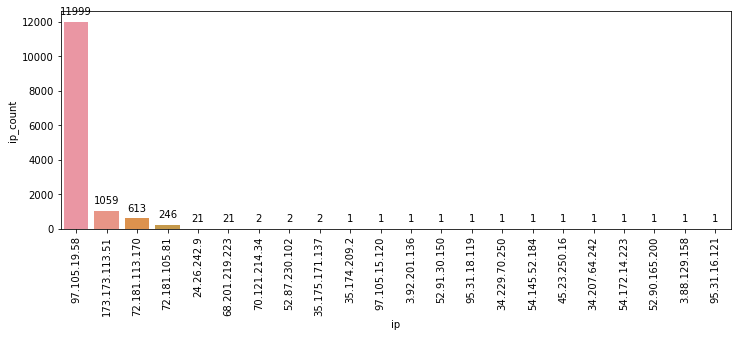

In [22]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

## Detecting anomalies by establishing a baseline and evaluate as new data arrives.

### Establish Baseline:

In [23]:
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]
train

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246
...,...,...,...,...,...,...,...
2019-04-17 12:55:12+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511544,NaN,python-requests/2.21.0,0.487846
2019-04-17 12:55:12+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511201,NaN,python-requests/2.21.0,0.487519
2019-04-17 12:55:13+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511781,NaN,python-requests/2.21.0,0.488072


### Compute probabilities based on train sample:

In [25]:
train.ip.value_counts(dropna=False)

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
68.201.219.223       21
70.121.214.34         2
35.175.171.137        2
52.87.230.102         2
45.23.250.16          1
34.229.70.250         1
54.145.52.184         1
34.207.64.242         1
54.172.14.223         1
52.90.165.200         1
3.88.129.158          1
52.91.30.150          1
3.92.201.136          1
35.174.209.2          1
Name: ip, dtype: int64

In [26]:
train.ip.count()

13974

In [28]:
pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index()

,index,ip
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,24.26.242.9,0.001503
5,68.201.219.223,0.001503
6,70.121.214.34,0.000143
7,35.175.171.137,0.000143
8,52.87.230.102,0.000143
9,45.23.250.16,0.000072


In [24]:
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df

,ip,ip_proba
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,24.26.242.9,0.001503
5,68.201.219.223,0.001503
6,70.121.214.34,0.000143
7,35.175.171.137,0.000143
8,52.87.230.102,0.000143
9,45.23.250.16,0.000072


### Merge probabilities with all data (train + new data):

Where the IP address is new, i.e. not seen in the training dataset, fill the probability with a value of 0.

In [29]:
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')

In [30]:
df

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba
timestamp,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595
...,...,...,...,...,...,...,...,...
2019-04-17 12:55:14+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510166,0,python-requests/2.21.0,0.486532,0.858595
2019-04-21 10:02:41+00:00,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,1153005,0,python-requests/2.21.0,1.099591,0.000000
2019-04-17 19:36:41+00:00,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,1005,0,python-requests/2.21.0,0.000958,0.000000


In [31]:
df.ip_proba.value_counts()

0.858595    11999
0.075784     1059
0.043867      613
0.017604      246
0.001503       42
0.000072       10
0.000143        6
0.000000        3
Name: ip_proba, dtype: int64

## Conditional Probabilities: Probabilities using 2 discrete variables

### Probability of Status given IP Address:
If we are looking for an unexpected status (like authentication failure) from a known/common IP address.

In [32]:
train.groupby('ip').size()

ip
173.173.113.51     1059
24.26.242.9          21
3.88.129.158          1
3.92.201.136          1
34.207.64.242         1
34.229.70.250         1
35.174.209.2          1
35.175.171.137        2
45.23.250.16          1
52.87.230.102         2
52.90.165.200         1
52.91.30.150          1
54.145.52.184         1
54.172.14.223         1
68.201.219.223       21
70.121.214.34         2
72.181.105.81       246
72.181.113.170      613
97.105.19.58      11998
dtype: int64

In [33]:
len(df)

13978

In [34]:
ip_probs = train.groupby('ip').size().div(len(df))

In [35]:
ip_probs

ip
173.173.113.51    0.075762
24.26.242.9       0.001502
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
34.229.70.250     0.000072
35.174.209.2      0.000072
35.175.171.137    0.000143
45.23.250.16      0.000072
52.87.230.102     0.000143
52.90.165.200     0.000072
52.91.30.150      0.000072
54.145.52.184     0.000072
54.172.14.223     0.000072
68.201.219.223    0.001502
70.121.214.34     0.000143
72.181.105.81     0.017599
72.181.113.170    0.043855
97.105.19.58      0.858349
dtype: float64

In [36]:
status_given_ip = pd.DataFrame(train.groupby(['ip', 'status']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )

In [37]:
status_given_ip

,ip,status,proba_status_given_ip
0,173.173.113.51,200,1.000286
1,24.26.242.9,200,1.000286
2,3.88.129.158,200,1.000286
3,3.92.201.136,200,1.000286
4,34.207.64.242,200,1.000286
5,34.229.70.250,200,1.000286
6,35.174.209.2,200,1.000286
7,35.175.171.137,200,1.000286
8,45.23.250.16,200,1.000286
9,52.87.230.102,200,1.000286


In [38]:
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'ip_status_count'}))

In [39]:
ip_status_count

,ip,status,ip_status_count
0,173.173.113.51,200,1059
1,24.26.242.9,200,21
2,3.88.129.158,200,1
3,3.92.201.136,200,1
4,34.207.64.242,200,1
5,34.229.70.250,200,1
6,35.174.209.2,200,1
7,35.175.171.137,200,2
8,45.23.250.16,200,1
9,52.87.230.102,200,2


In [40]:
ip_status = status_given_ip.merge(ip_status_count)
ip_status

,ip,status,proba_status_given_ip,ip_status_count
0,173.173.113.51,200,1.000286,1059
1,24.26.242.9,200,1.000286,21
2,3.88.129.158,200,1.000286,1
3,3.92.201.136,200,1.000286,1
4,34.207.64.242,200,1.000286,1
5,34.229.70.250,200,1.000286,1
6,35.174.209.2,200,1.000286,1
7,35.175.171.137,200,1.000286,2
8,45.23.250.16,200,1.000286,1
9,52.87.230.102,200,1.000286,2


### Add these probabilities to original events to detect anomalous events:

In [41]:
df = df.reset_index().merge(ip_status, on=['ip', 'status'], how='left').fillna(value=0).set_index('timestamp')

In [42]:
df

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.999119,11984.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.999119,11984.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.999119,11984.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.999119,11984.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.999119,11984.0
...,...,...,...,...,...,...,...,...,...,...
2019-04-17 12:55:14+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510166,0,python-requests/2.21.0,0.486532,0.858595,0.999119,11984.0
2019-04-21 10:02:41+00:00,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,1153005,0,python-requests/2.21.0,1.099591,0.000000,0.000000,0.0
2019-04-17 19:36:41+00:00,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,1005,0,python-requests/2.21.0,0.000958,0.000000,0.000000,0.0


Text(0, 0.5, 'Probability of seeing this given IP address')

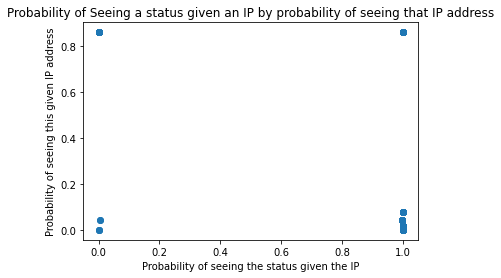

In [43]:
plt.scatter(df.proba_status_given_ip, df.ip_proba)
plt.title('Probability of Seeing a status given an IP by probability of seeing that IP address')
plt.xlabel('Probability of seeing the status given the IP')
plt.ylabel('Probability of seeing this given IP address')

## Exercise

### Discrete Data + Probability
Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [44]:
df

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858595,0.999119,11984.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858595,0.999119,11984.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858595,0.999119,11984.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858595,0.999119,11984.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858595,0.999119,11984.0
...,...,...,...,...,...,...,...,...,...,...
2019-04-17 12:55:14+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510166,0,python-requests/2.21.0,0.486532,0.858595,0.999119,11984.0
2019-04-21 10:02:41+00:00,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,1153005,0,python-requests/2.21.0,1.099591,0.000000,0.000000,0.0
2019-04-17 19:36:41+00:00,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,1005,0,python-requests/2.21.0,0.000958,0.000000,0.000000,0.0


In [45]:
df.request_method.value_counts()

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1items HTTP/1.1                           2
GET /api/v1/items&page=0 HTTP/1.1                   1
GET /api/v1//api/v1/items/next_page HTTP/1.1        1
GET /api/v1 HTTP/1.1                                1
GET /api/v1/I_DIDNT_DO_IT!!!

In [46]:
pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index()

,index,request_method
0,GET /api/v1/sales HTTP/1.1,12403
1,GET /api/v1/items HTTP/1.1,1065
2,GET /api/v1/stores HTTP/1.1,229
3,GET / HTTP/1.1,107
4,GET /documentation HTTP/1.1,100
5,GET /favicon.ico HTTP/1.1,26
6,GET /api/v1//api/v1/items HTTP/1.1,11
7,GET /api/v1/items/api/v1/items HTTP/1.1,7
8,GET /api/v1/items/next_page HTTP/1.1,5
9,GET /api/v1/ HTTP/1.1,4


In [47]:
rm_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_method_count'})
rm_df2 = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'request_method_proba'})
rm_df = rm_df.merge(rm_df2)
rm_df

,request_method,request_method_count,request_method_proba
0,GET /api/v1/sales HTTP/1.1,12403,0.887323
1,GET /api/v1/items HTTP/1.1,1065,0.076191
2,GET /api/v1/stores HTTP/1.1,229,0.016383
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286


In [49]:
# see those where rate < 1% 
rm_df[rm_df.request_method_proba < .01]

,request_method,request_method_count,request_method_proba
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286
10,GET /api/v1/sales/HTTP/1.1,3,0.000215
11,GET /api/v1/sales/ HTTP/1.1,3,0.000215
12,GET /api/v1/store HTTP/1.1,3,0.000215


22
                                  request_method  request_method_count  \
12                    GET /api/v1/store HTTP/1.1                     3   
13               GET /api/v1/itemsitems HTTP/1.1                     3   
14                     GET /api/v1items HTTP/1.1                     2   
15             GET /api/v1/items&page=0 HTTP/1.1                     1   
16  GET /api/v1//api/v1/items/next_page HTTP/1.1                     1   
17                          GET /api/v1 HTTP/1.1                     1   
18        GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1                     1   
19              GET /api/v1/helloclass! HTTP/1.1                     1   
20                  GET /api/V1/HiZach! HTTP/1.1                     1   
21                    GET /api/v1/items/HTTP/1.1                     1   

    request_method_proba  
12              0.000215  
13              0.000215  
14              0.000143  
15              0.000072  
16              0.000072  
17              0.00

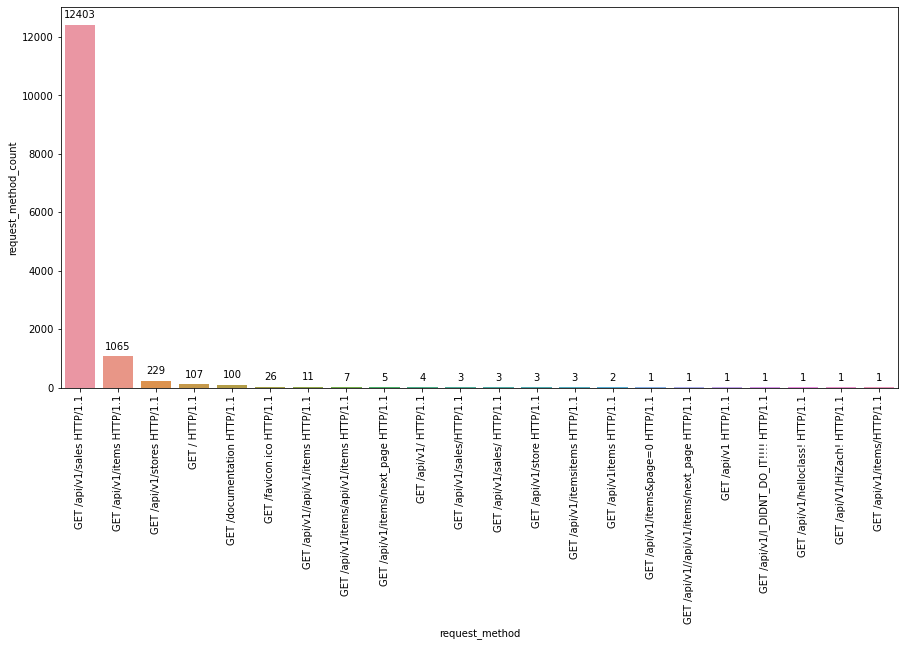

In [54]:
print(len(rm_df))

print(rm_df.tail(10))

plt.figure(figsize=(15, 7))
splot = sns.barplot(data=rm_df, x = 'request_method', y = 'request_method_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

### Identifying anomalous request agents

In [56]:
ra_df = pd.DataFrame(df.request_agent.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'request_agent_count'})
ra_df2 = pd.DataFrame(df.request_agent.value_counts(dropna=False)/df.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'request_agent_proba'})
ra_df = ra_df.merge(ra_df2)
ra_df

,request_agent,request_agent_count,request_agent_proba
0,python-requests/2.21.0,12005,0.858850
1,python-requests/2.20.1,1911,0.136715
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


In [57]:
# see those where rate < 1% 
ra_df[ra_df.request_agent_proba < .01]

,request_agent,request_agent_count,request_agent_proba
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


9
                                       request_agent  request_agent_count  \
0                             python-requests/2.21.0                12005   
1                             python-requests/2.20.1                 1911   
2  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...                   34   
3  Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...                    8   
4  Slackbot-LinkExpanding 1.0 (+https://api.slack...                    7   
5       Slackbot 1.0 (+https://api.slack.com/robots)                    6   
6  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...                    4   
7  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...                    2   
8                                  Python-urllib/3.7                    1   

   request_agent_proba  
0             0.858850  
1             0.136715  
2             0.002432  
3             0.000572  
4             0.000501  
5             0.000429  
6             0.000286  
7             0.000143  
8 

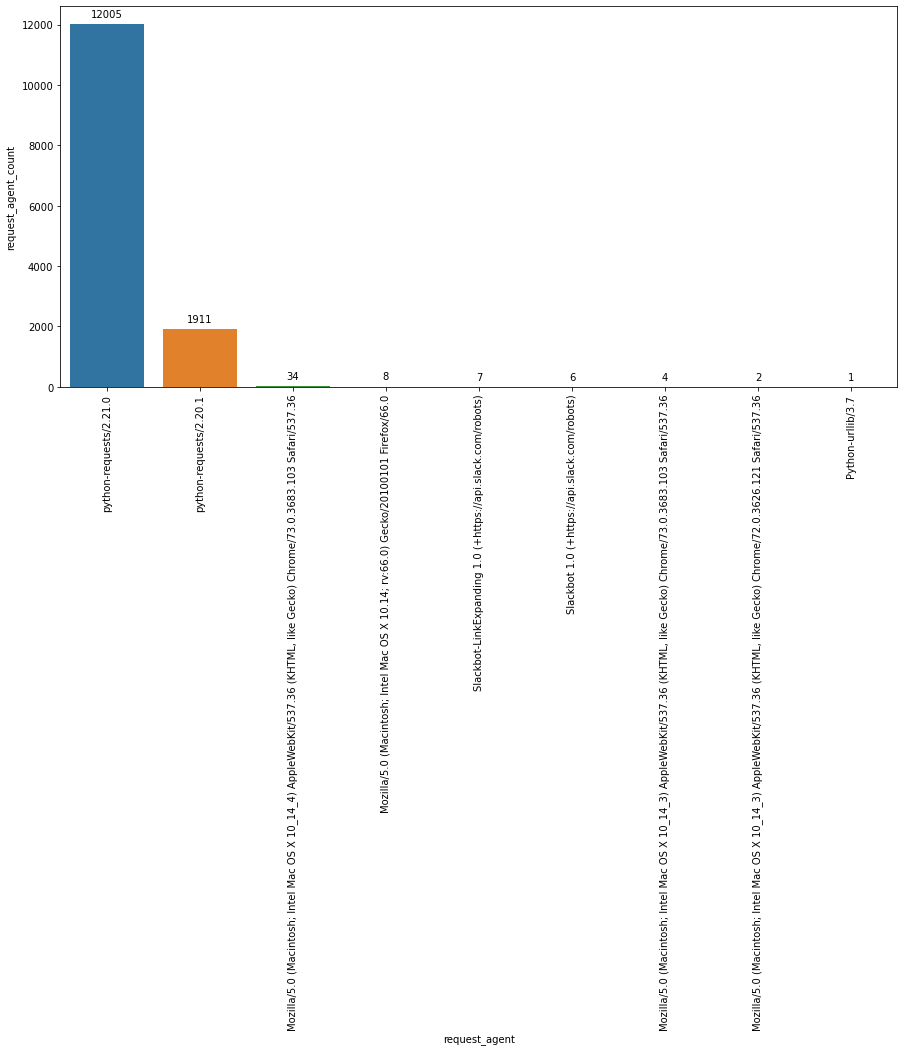

In [59]:
print(len(ra_df))

print(ra_df.tail(10))

plt.figure(figsize=(15, 7))
splot = sns.barplot(data=ra_df, x = 'request_agent', y = 'request_agent_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')